# Greate parameter entries for synthetic grid points

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
# import corner
from pathlib import Path
from scipy.io.idl import readsav
import time

In [70]:
# Read in the previous data release as well as the MARCS2014 atmosphere grid
# try:
#     data = Table.read('/Users/svenbuder/GALAH_DR3/catalogs/GALAH_DR3_all_joined_v2.fits')
# except:
#     data = Table.read('/Users/sven/GALAH_DR3/catalogs/GALAH_DR3_all_joined_v2.fits')
# data = Table.read('/avatar/buder/GALAH_DR4/catalogs/galah_dr4_allstar_230531.fits')
marcs2014 = readsav('/avatar/buder/trunk/sme_580/atmospheres/marcs2014.sav')

In [5]:
# def plot_teff_logg_coverage():
#     unflagged = np.isfinite(data['teff'])
#     f, ax = plt.subplots(figsize=(5,3.5))
#     corner.hist2d(
#         data['teff'][unflagged],
#         data['logg'][unflagged],
#         bins=75,
#         levels=(0.4,0.7,0.86,),
#         data_kwargs=dict(label='GALAH+ DR3',alpha=0.1),
#         ax=ax
#     )
#     ax.scatter(
#         marcs2014['atmo_grid']['teff'],
#         marcs2014['atmo_grid']['logg'],
#         label='MARCS2014',
#         s=10,c='r',
#         zorder=4
#     )
#     ax.add_patch(Rectangle((5750-250, 4.0), 500, 1.0,color="C0"))
#     ax.text(5750,5.5,'Example 3D Bin',ha='center',va='center',color='C0',fontsize=15)
#     ax.text(2700,2.5,'Neglected',ha='center',va='center',color='k',fontsize=15,rotation=90,zorder=5)
#     ax.axvspan(2000,3100,color='grey')
#     ax.legend(loc='upper left')
#     ax.set_xlim(8250,2350)
#     ax.set_ylim(6.,-1.)
#     ax.set_xlabel(r'$T_\mathrm{eff}$ / K')
#     ax.set_ylabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$')
#     plt.tight_layout()
#     plt.savefig('../galah_dr4_paper/figures/teff_logg_grid_coverage.png',dpi=200,bbox_inches='tight')
#     print('\caption{Coverage in \Teff and \logg of MARCS2014 grid (red) and GALAH DR3 (black, including density countour). Shown is also an example of one of the 3D bins used to create models with \TheCannon/\ThePayne. MARCS grid points \Teff$\leq3100\K$ are neglected throughout GALAH DR4.}')

# plot_teff_logg_coverage()

## Create a set of subgrids in 3D bins of $T_\text{eff}$, $\log g$, and [Fe/H]

In [87]:
# First let's use all uniqe grid points
teff_points = np.unique(marcs2014['atmo_grid']['TEFF'])
logg_points = np.unique(marcs2014['atmo_grid']['LOGG'])
fe_h_points = np.unique(marcs2014['atmo_grid']['MONH'])
# Now let's ignore the Teff <= 3100 K
teff_points = teff_points[teff_points>=3000]
fe_h_points = fe_h_points[fe_h_points>=-4]

# We will want to safe a FITS file that will help us to identify the individual subgrids
subgrid_index = []
subgrid_teff_low = []
subgrid_teff_mid = []
subgrid_teff_high = []
subgrid_logg_low = []
subgrid_logg_mid = []
subgrid_logg_high = []
subgrid_fe_h_low = []
subgrid_fe_h_mid = []
subgrid_fe_h_high = []
subgrid_seed = []

running_subgrid_index = 0

extended_subgrid_index = 2499

# Now let's loop through all available teff/logg/feh and take +- 1 from the unique grid points
for teff in teff_points[1:-1]:
    for logg in logg_points[1:-1]:
        for fe_h in fe_h_points[1:-1]:
                        
            teff_i = np.where(teff==teff_points)[0][0]
            logg_i = np.where(logg==logg_points)[0][0]
            fe_h_i = np.where(fe_h==fe_h_points)[0][0]
            
            gridpoints = np.where((
                    (marcs2014['atmo_grid']['TEFF'] >= teff_points[teff_i-1]) &
                    (marcs2014['atmo_grid']['TEFF'] <= teff_points[teff_i+1]) &
                    (marcs2014['atmo_grid']['LOGG'] >= logg_points[logg_i-1]) &
                    (marcs2014['atmo_grid']['LOGG'] <= logg_points[logg_i+1]) &
                    (marcs2014['atmo_grid']['MONH'] >= fe_h_points[fe_h_i-1]) &
                    (marcs2014['atmo_grid']['MONH'] <= fe_h_points[fe_h_i+1])
                ) == True)[0]

            if len(gridpoints) > 18:
                subgrid_index.append(running_subgrid_index)
                subgrid_teff_low.append(teff_points[teff_i-1])
                subgrid_teff_mid.append(teff)
                subgrid_teff_high.append(teff_points[teff_i+1])
                
                subgrid_logg_low.append(logg_points[logg_i-1])
                subgrid_logg_mid.append(logg)
                subgrid_logg_high.append(logg_points[logg_i+1])

                subgrid_fe_h_low.append(fe_h_points[fe_h_i-1])
                subgrid_fe_h_mid.append(fe_h)
                subgrid_fe_h_high.append(fe_h_points[fe_h_i+1])
                
                subgrid_seed.append(int(teff+10*logg+100*fe_h))

                running_subgrid_index += 1
                
            # extend for luminous giants with Teff <= 4250 & logg <= 0.5 where there are at least 14 points (50% of all)
            elif (len(gridpoints) >= 14) & (logg <= 0.5) & (teff <= 4250):
                subgrid_index.append(extended_subgrid_index)
                subgrid_teff_low.append(teff_points[teff_i-1])
                subgrid_teff_mid.append(teff)
                subgrid_teff_high.append(teff_points[teff_i+1])
                
                subgrid_logg_low.append(logg_points[logg_i-1])
                subgrid_logg_mid.append(logg)
                subgrid_logg_high.append(logg_points[logg_i+1])

                subgrid_fe_h_low.append(fe_h_points[fe_h_i-1])
                subgrid_fe_h_mid.append(fe_h)
                subgrid_fe_h_high.append(fe_h_points[fe_h_i+1])
                
                subgrid_seed.append(int(teff+10*logg+100*fe_h))

                extended_subgrid_index += 1

print(running_subgrid_index)
print(extended_subgrid_index-2499)

# minimum_number_of_entries_per_bin = np.arange(28)
# entries_per_bin = [3300,3158,3136,3121,3098,3071,3043,3017,2997,2979,2950,2925,2906,2871,2845,2820,2793,2760,2726,2499,2452,2386,2297,2223,2129,1994,1842,1584]
# change from 19 down to 18 introduces teff > 4000 & logg=5.0 as an unreasonable option

2499
48


In [110]:
subgrid_table = Table()
subgrid_table['index_subgrid'] = np.array(subgrid_index)

subgrid_table['teff_subgrid'] = np.array(subgrid_teff_mid)
subgrid_table['teff_low_subgrid'] = np.array(subgrid_teff_low)
subgrid_table['teff_high_subgrid'] = np.array(subgrid_teff_high)

subgrid_table['logg_subgrid'] = np.array(subgrid_logg_mid)
subgrid_table['logg_low_subgrid'] = np.array(subgrid_logg_low)
subgrid_table['logg_high_subgrid'] = np.array(subgrid_logg_high)

subgrid_table['fe_h_subgrid'] = np.array(subgrid_fe_h_mid)
subgrid_table['fe_h_low_subgrid'] = np.array(subgrid_fe_h_low)
subgrid_table['fe_h_high_subgrid'] = np.array(subgrid_fe_h_high)

subgrid_table['random_seed_subgrid'] = np.array(subgrid_seed)

subgrid_table.sort('index_subgrid')

subgrid_table.write('galah_dr4_model_trainingset_gridpoints.fits',overwrite='True')

subgrid_table

# subgrid_table = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

index_subgrid,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
0,3100.0,3000.0,3200.0,0.5,0.0,1.0,-2.0,-2.5,-1.5,2905
1,3100.0,3000.0,3200.0,0.5,0.0,1.0,-1.5,-2.0,-1.0,2955
2,3100.0,3000.0,3200.0,0.5,0.0,1.0,-1.0,-1.5,-0.75,3005
3,3100.0,3000.0,3200.0,0.5,0.0,1.0,-0.75,-1.0,-0.5,3030
4,3100.0,3000.0,3200.0,0.5,0.0,1.0,-0.5,-0.75,-0.25,3055
5,3100.0,3000.0,3200.0,0.5,0.0,1.0,-0.25,-0.5,0.0,3080
6,3100.0,3000.0,3200.0,0.5,0.0,1.0,0.0,-0.25,0.25,3105
7,3100.0,3000.0,3200.0,1.0,0.5,1.5,-3.0,-4.0,-2.5,2810
8,3100.0,3000.0,3200.0,1.0,0.5,1.5,-2.5,-3.0,-2.0,2860


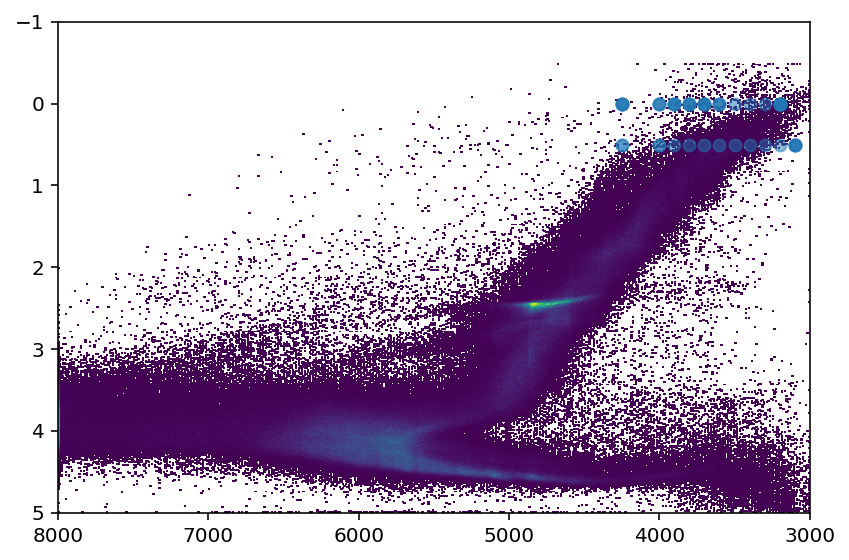

In [92]:
# Where to we extend?

plt.hist2d(
    data['teff'],
    data['logg'],
    bins = 500,
    cmin = 1,
    range = [(3000,8000),(-1,5)]
)
plt.scatter(
    subgrid_table[2499:]['teff_subgrid'],
    subgrid_table[2499:]['logg_subgrid'],
    alpha = 0.5
)
plt.xlim(plt.xlim()[::-1])
plt.ylim(plt.ylim()[::-1])
plt.tight_layout()

# Calculate 280 points

In [93]:
def calculate_sme_abundance_table(sample):
    #       "H",  "He",  "Li",  "Be",   "B",   "C",   "N",   "O",   "F",  "Ne",
    a_x= [12.00, 10.93,  1.05,  1.38,  2.70,  8.39,  7.78,  8.66,  4.56,  7.84,
    #      "Na",  "Mg",  "Al",  "Si",   "P",   "S",  "Cl",  "Ar",   "K",  "Ca",
           6.17,  7.53,  6.37,  7.51,  5.36,  7.14,  5.50,  6.18,  5.08,  6.31,
    #      "Sc",  "Ti",   "V",  "Cr",  "Mn",  "Fe",  "Co",  "Ni",  "Cu",  "Zn",
           3.17,  4.90,  4.00,  5.64,  5.39,  7.45,  4.92,  6.23,  4.21,  4.60,
    #      "Ga",  "Ge",  "As",  "Se",  "Br",  "Kr",  "Rb",  "Sr",   "Y",  "Zr",
           2.88,  3.58,  2.29,  3.33,  2.56,  3.25,  2.60,  2.92,  2.21,  2.58,
    #      "Nb",  "Mo",  "Tc",  "Ru",  "Rh",  "Pd",  "Ag",  "Cd",  "In",  "Sn",
           1.42,  1.92, -8.00,  1.84,  1.12,  1.66,  0.94,  1.77,  1.60,  2.00,
    #      "Sb",  "Te",   "I",  "Xe",  "Cs",  "Ba",  "La",  "Ce",  "Pr",  "Nd",
           1.00,  2.19,  1.51,  2.24,  1.07,  2.17,  1.13,  1.70,  0.58,  1.45,
    #      "Pm",  "Sm",  "Eu",  "Gd",  "Tb",  "Dy",  "Ho",  "Er",  "Tm",  "Yb",
          -8.00,  1.00,  0.52,  1.11,  0.28,  1.14,  0.51,  0.93,  0.00,  1.08,
    #      "Lu",  "Hf",  "Ta",   "W",  "Re",  "Os",  "Ir",  "Pt",  "Au",  "Hg",
           0.06,  0.88, -0.17,  1.11,  0.23,  1.25,  1.38,  1.64,  1.01,  1.13,
    #      "Tl",  "Pb",  "Bi",  "Po",  "At",  "Rn",  "Fr",  "Ra",  "Ac",  "Th",
           0.90,  2.00,  0.65, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00,  0.06,
    #      "Pa",   "U",  "Np",  "Pu",  "Am",  "Cm",  "Bk",  "Cs",  "Es", "TiO" 
          -8.00, -0.52, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00, -8.00]
    log_eonh = np.array(a_x) - 12.0
    
    elements = np.array(['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu'])
    element_indices = np.array([3,6,7,8,11,12,13,14,19,20,21,22,23,24,25,27,28,29,30,37,38,39,40,42,44,56,57,58,60,62,63])-1
    
    for index, element in enumerate(elements):
        element_index = element_indices[index]
        log_eonh[element_index] += sample[element.lower()+'_fe']
    
    eonh = 10**log_eonh
    renorm = np.sum(eonh)
    eontot = eonh / renorm
    log_eontot = np.log10(eontot).astype(np.float)
    abund = log_eontot
    abund[0] = eonh[0] / renorm
    abund = abund.astype(np.float)
    return(abund)

In [94]:
coefficient_test_labels = [
    'teff','logg','fe_h','vmic',
    'li_fe','c_fe','n_fe','o_fe',
    'na_fe','mg_fe','al_fe','si_fe',
    'k_fe','ca_fe','sc_fe','ti_fe','v_fe','cr_fe','mn_fe','co_fe','ni_fe','cu_fe','zn_fe',
    'rb_fe','sr_fe','y_fe','zr_fe','mo_fe','ru_fe',
    'ba_fe','la_fe','ce_fe','nd_fe','sm_fe','eu_fe'
]

In [95]:
def vmic_DF16(teff, logg):
    """
    Adjusted by +0.2
    https://ui.adsabs.harvard.edu/abs/2016A%26A...585A..75D/abstract
    """
    return 0.2+0.998+3.16*10**(-4)*(teff-5500.)-0.253*(logg-4.0)-2.86*10**(-4)*(teff-5500)*(logg-4.0)+0.165*(logg-4.0)**2.

In [96]:
def vmic_GALAH_DR3(teff, logg):
    if (logg <= 4.2) | (teff >= 5500):
        vmic = 1.1 + 10**(-4)*(teff - 5500) + 4*10**(-7)*(teff - 5500)**2
    else:
        vmic = 1.5 + 2*10**(-4)*(teff - 5500)
    return vmic

In [107]:
for index in subgrid_table['index_subgrid'][2499:]: #[1931]:
        
    coefficient_test = dict()
    coefficient_test['spectrum_index'] = []
    for label in coefficient_test_labels:
        coefficient_test[label] = []

    grid_table = Table()
    spectrum_index = 0

    np.random.seed(subgrid_table['random_seed_subgrid'][index])
    
    teff_logg_feh_name = str(int(subgrid_table['teff_subgrid'][index]))+'_'+"{:.2f}".format(subgrid_table['logg_subgrid'][index])+'_'+"{:.2f}".format(subgrid_table['fe_h_subgrid'][index])
        
    # let's create the null spectrum
    coefficient_test['spectrum_index'].append(spectrum_index)
    label_values = dict()
    for label in coefficient_test_labels:
        if label in ['teff','logg','fe_h']:
            label_values[label] = subgrid_table[label+'_subgrid'][index]
        elif label == 'vmic':
            label_values[label] = 1.5
        elif label == 'li_fe':
            label_values[label] = 2.75 - 1.05 - label_values['fe_h'] # SBBN A(Li) - A(Li_sun) from Pitrou+18 and Asplund+09
        else:
            label_values[label] = 0.0
        coefficient_test[label].append(label_values[label])
            
    spectrum_index += 1
    
    # let's create another null spectrum, but this time with an adjusted vmic
    coefficient_test['spectrum_index'].append(spectrum_index)
    label_values = dict()
    for label in coefficient_test_labels:
        if label in ['teff','logg','fe_h']:
            label_values[label] = subgrid_table[label+'_subgrid'][index]
        elif label == 'vmic':
            label_values[label] = vmic_DF16(label_values['teff'], label_values['logg'])
        elif label == 'li_fe':
            label_values[label] = 2.75 - 1.05 - label_values['fe_h'] # SBBN A(Li) - A(Li_sun) from Pitrou+18 and Asplund+09
        else:
            label_values[label] = 0.0
        coefficient_test[label].append(label_values[label])
            
    spectrum_index += 1

    # let's create the spectra with 1 parameter increased at a time
    for coefficient_label in coefficient_test_labels:
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = subgrid_table[label+'_subgrid'][index]
                if coefficient_label == label:
                    label_values[label] = subgrid_table[label+'_high_subgrid'][index]
            elif label == 'vmic':
                label_values[label] = 1.5
                if coefficient_label == label:
                    label_values[label] += 1.0
            elif label == 'li_fe':
                label_values[label] = 2.75 - 1.05 - subgrid_table['fe_h_subgrid'][index] # SBBN A(Li) - A(Li_sun) from Pitrou et al. (2018) and Asplund et al. (2009)
                if coefficient_label == label:
                    label_values[label] = +4.0 - 1.05 - label_values['fe_h'] # A(Li) = 4.0
            elif label in ['c_fe','n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] += 1.5
            elif label in ['mg_fe', 'si_fe','ti_fe']:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] += 1.0
            else:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] += 1.0
            coefficient_test[label].append(label_values[label])
        
        spectrum_index += 1
    
    # let's create the spectra with 1 parameter decreased at a time
    for coefficient_label in coefficient_test_labels:
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = subgrid_table[label+'_subgrid'][index]
                if coefficient_label == label:
                    label_values[label] = subgrid_table[label+'_low_subgrid'][index]
            elif label == 'vmic':
                label_values[label] = 1.5
                if coefficient_label == label:
                    label_values[label] -= 1.0
            elif label == 'li_fe':
                label_values[label] = 2.75 - 1.05 - subgrid_table['fe_h_subgrid'][index] # SBBN A(Li) - A(Li_sun) from Pitrou et al. (2018) and Asplund et al. (2009)
                if coefficient_label == label:
                    label_values[label] = 0.0 - 1.05 - label_values['fe_h'] # A(Li) = -1.0
            elif label in ['c_fe','n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] -= 1.0
            elif label in ['mg_fe', 'si_fe','ti_fe']:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] -= 0.5
            else:
                label_values[label] = 0.0
                if coefficient_label == label:
                    label_values[label] -= 1.0
            coefficient_test[label].append(label_values[label])
        
        spectrum_index += 1

    # let's create the spectra with +- 0.5 dex
    for each_sample_index in range(104):
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = np.random.uniform(
                    low = subgrid_table[label+'_low_subgrid'][index],
                    high = subgrid_table[label+'_high_subgrid'][index]
                )
            elif label == 'vmic':
                vmic_dr3 = vmic_GALAH_DR3(label_values['teff'], label_values['logg'])
                vmic_df16 = vmic_DF16(label_values['teff'], label_values['logg'])
                label_values[label] = np.random.uniform(
                    low = np.max(
                        [0.5, # We should not sample below 0.5
                         np.min([
                             vmic_dr3,
                             vmic_df16
                         ])-1
                        ]),
                    high = np.min(
                        [4.0,
                         np.max([
                             vmic_dr3,
                             vmic_df16
                         ])+1
                        ])
                )
            elif label == 'li_fe':
                label_values[label] = np.random.uniform(
                    low = 1.05, # A(Li_sun) (Asplund et al., 2009)
                    high = 3.26 # A(Li_meteorites) (Asplund et al., 2009)
                ) - 1.05 - label_values['fe_h']
            elif label in ['c_fe','n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
                label_values[label] = np.random.uniform(
                    low = -0.5,
                    high = 1.0
                )
            else:
                label_values[label] = np.random.uniform(
                    low = -0.5,
                    high = +0.5
                )
            coefficient_test[label].append(label_values[label])
        spectrum_index += 1

    # let's create the spectra with +- 1.0 dex
    for each_sample_index in range(104):
        coefficient_test['spectrum_index'].append(spectrum_index)
        label_values = dict()
        for label in coefficient_test_labels:
            if label in ['teff','logg','fe_h']:
                label_values[label] = np.random.uniform(
                    low = subgrid_table[label+'_low_subgrid'][index],
                    high = subgrid_table[label+'_high_subgrid'][index]
                )
            elif label == 'vmic':
                vmic_dr3 = vmic_GALAH_DR3(label_values['teff'], label_values['logg'])
                vmic_df16 = vmic_DF16(label_values['teff'], label_values['logg'])
                label_values[label] = np.random.uniform(
                    low = np.max(
                        [0.5, # We should not sample below 0.5
                         np.min([
                             vmic_dr3,
                             vmic_df16
                         ])-1
                        ]),
                    high = np.min(
                        [4.0,
                         np.max([
                             vmic_dr3,
                             vmic_df16
                         ])+1
                        ])
                )
            elif label == 'li_fe':
                label_values[label] = np.random.uniform(
                    low = 0.0, # A(Li) = 0.0
                    high = +4.0 # A(Li) = 4.0
                ) - 1.05 - label_values['fe_h']
            elif label in ['c_fe','n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
                label_values[label] = np.random.uniform(
                    low = -1.0,
                    high = 1.5
                )
            elif label in ['mg_fe', 'si_fe','ti_fe']:
                label_values[label] = np.random.uniform(
                    low = -0.5,
                    high = 1.0
                )
            else:
                label_values[label] = np.random.uniform(
                    low = -1.0,
                    high = +1.0
                )
            coefficient_test[label].append(label_values[label])
        spectrum_index += 1
    
    grid_table['grid_index'] = np.array([index for x in range(280)])
    grid_table['spectrum_index'] = np.array(coefficient_test['spectrum_index'])
    for label in coefficient_test_labels:
        grid_table[label] = np.array(coefficient_test[label],dtype=np.float32)
        
    grid_table['sme_abund'] = np.array([calculate_sme_abundance_table(sample=grid_table[index]) for index in range(len(grid_table))])
    
    Path('3d_bin_subgrids/'+teff_logg_feh_name).mkdir(parents=True, exist_ok=True)
    grid_table.write('3d_bin_subgrids/'+teff_logg_feh_name+'/galah_dr4_trainingset_'+teff_logg_feh_name+'.fits',overwrite=True)

In [108]:
# Plot example of one 3D bin
teff_logg_feh_name = '5750_4.50_0.00'
example = Table.read('3d_bin_subgrids/'+teff_logg_feh_name+'/galah_dr4_trainingset_'+teff_logg_feh_name+'.fits')

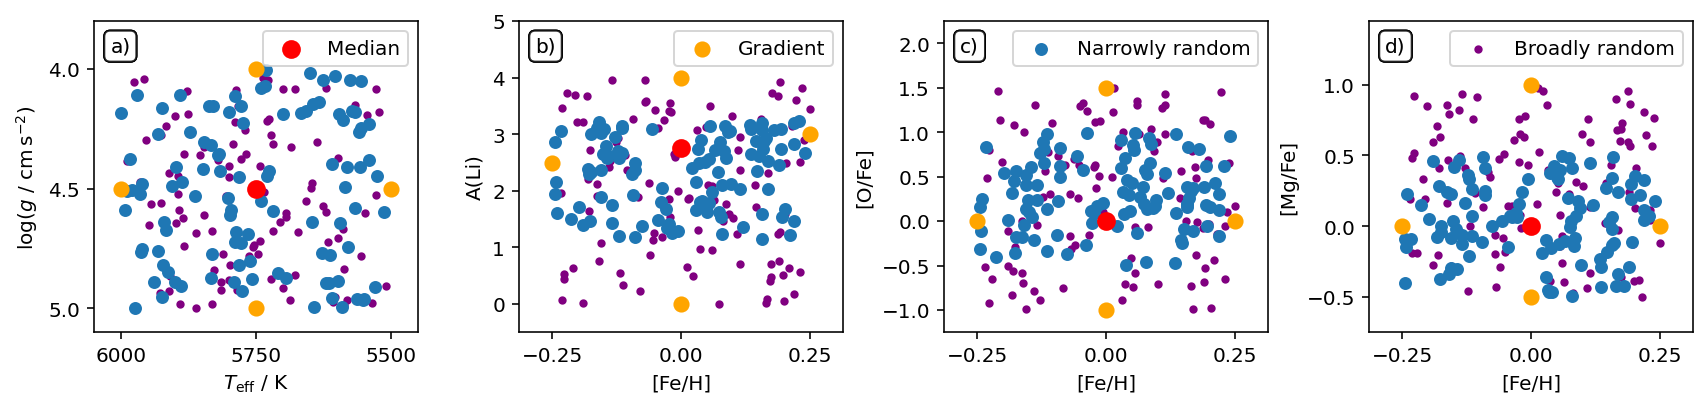

In [109]:
f, gs = plt.subplots(1,4,figsize=(12,3))

colors = ['purple','C0','orange','red']
labels = ['Broadly random','Narrowly random','Gradient','Median']
size = [10,30,50,70]
panels = ['a)','b)','c)','d)']
for index, examples in enumerate([np.arange(72+104,280),np.arange(72,72+104),np.arange(1,72),[0]]):

    # Teff vs. logg
    ax=gs[0]
    legend_label = ['_nolegend_','_nolegend_','_nolegend_','Median']
    ax.scatter(
        example['teff'][examples],
        example['logg'][examples],
        c=colors[index],
        s=size[index],
        label=legend_label[index]
    )
    ax.set_xlim(6050,5450)
    ax.set_ylim(5.1,3.8)
    ax.set_yticks([4.0,4.5,5.0])
    ax.set_xticks([5500,5750,6000])
    ax.set_xlabel('$T_\mathrm{eff}~/~\mathrm{K}$')
    ax.set_ylabel('$\log (g~/~\mathrm{cm\,s^{-2}})$')
    ax.text(0.05,0.95,panels[0],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    if index == 3:
        ax.legend(loc='upper right')

    # fe_h vs. li_fe
    ax=gs[1]
    legend_label = ['_nolegend_','_nolegend_','Gradient','_nolegend_']
    ax.scatter(
        example['fe_h'][examples],
        example['li_fe'][examples] + example['fe_h'][examples] + 1.05,
        c=colors[index],
        s=size[index],
        label=legend_label[index]
    )
    ax.set_xlim(-0.315,0.315)
    ax.set_ylim(-0.5,5)
    ax.set_xticks([-0.25,0,0.25])
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('A(Li)')
    ax.text(0.05,0.95,panels[1],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    if index == 3:
        ax.legend(loc='upper right')

    # fe_h vs. o_fe
    ax=gs[2]
    legend_label = ['_nolegend_','Narrowly random','_nolegend_','_nolegend_']
    ax.scatter(
        example['fe_h'][examples],
        example['o_fe'][examples],
        c=colors[index],
        s=size[index],
        label=legend_label[index]
    )
    ax.set_xlim(-0.315,0.315)
    ax.set_ylim(-1.25,2.25)
    ax.set_xticks([-0.25,0,0.25])
    ax.text(0.05,0.95,panels[2],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    if index == 3:
        ax.legend(loc='upper right')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    
    # fe_h vs. mg_fe
    ax=gs[3]
    legend_label = ['Broadly random','_nolegend_','_nolegend_','_nolegend_']
    ax.scatter(
        example['fe_h'][examples],
        example['mg_fe'][examples],
        c=colors[index],
        s=size[index],
        label=legend_label[index]
    )
    ax.set_xlim(-0.315,0.315)
    ax.set_ylim(-0.75,1.45)
    ax.set_xticks([-0.25,0,0.25])
    ax.text(0.05,0.95,panels[3],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    if index == 3:
        ax.legend(loc='upper right')
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Mg/Fe]')
plt.tight_layout(w_pad=0.5)

try:
    plt.savefig('../galah_dr4_paper/figures/example_3d_bin_sample.png',dpi=200,bbox_inches='tight')
    print(r'\caption{\textbf{Coverage of stellar parameters and abundances for one of the 3D bins.} Shown is the example of the solar 3D bin ($T_\mathrm{eff}~/~\mathrm{K} = 5750$, $\log (g~/~\mathrm{cm\,s^{-2}}) = 4.5$, $\mathrm{[Fe/H]}~/~\mathrm{dex} = 0.0$). \textbf{Panel a):} \Teff and \logg, \textbf{Panel b):} [Fe/H] vs. [Li/Fe], \textbf{Panel c):} [Fe/H] vs. [O/Fe], \textbf{Panel d):} [Fe/H] vs. [Mg/Fe]. While \Teff, \logg, and \feh are sampled randomly within the 3D bin, the abundances are sampled both narrowly (blue) and broadly (purple) within limits as described in the text. Red point indicate the median spectrum and orange points the adjusted spectra to test the gradient change of spectra with individual label.}')
except:
    pass